In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

In [11]:
%tensorflow_version 1.x
import tensorflow as tf1

print(tf1.__version__)

1.15.2


# Load data

In [12]:
from google.colab import drive

drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


In [13]:
mnist_df = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/lazyprogrammer/data/mnist.csv', header='infer')

if mnist_df.isna().sum().max() == 0:
  print('There is no NA values')
else:
  print(f'There are {mnist_df.isna().sum().max()} NAs' )

print(mnist_df.info())
mnist_df.head(10)

There is no NA values
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42000 entries, 0 to 41999
Columns: 785 entries, label to pixel783
dtypes: int64(785)
memory usage: 251.5 MB
None


,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [14]:
RANDOM_STATE = 123

def _get_mnist_data_raw():
    print("Reading in and transforming data...")
    df = mnist_df
    data = df.values
    X = data[:, 1:].astype(np.float32)
    Y = data[:, 0].astype(int)
    assert X.shape[1] == 28 * 28
    picture_shape = (28, 28)
    return X, Y, picture_shape


def get_mnist_normalized_data(train_size=0.8, should_plot_examples=True):
    assert train_size != 0
    X, Y, picture_shape = _get_mnist_data_raw()

    if 0.0 < train_size < 1.0:
        X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=1-train_size, random_state=RANDOM_STATE)
    elif train_size == 1:
        X_train, Y_train = shuffle(X, Y, random_state=RANDOM_STATE)
        X_test, Y_test = None, None
    else:
        if isinstance(train_size, int):
            X, Y = shuffle(X, Y, random_state=RANDOM_STATE)
            X_train, Y_train = X[:train_size, :], Y[:train_size]
            X_test, Y_test = X[train_size:, :], Y[train_size:]
        else:
            raise Exception(f'Wrong test size value or type. Value:{train_size}, type:{type(train_size)}')

    # normalize the data
    mu = X_train.mean(axis=0)
    std = X_train.std(axis=0)
    np.place(std, std == 0, 1)
    X_train = (X_train - mu) / std
    X_test = (X_test - mu) / std

    if should_plot_examples:
        plot_examples(X.reshape((-1, *picture_shape)), Y, cmap='gray', labels=None)
    return X_train, X_test, Y_train, Y_test, picture_shape


def plot_examples(x, y, cmap='gray', labels=None):
    plt.figure(figsize=(15, 15))
    for i in range(25):
        plt.subplot(5, 5, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(x[i], cmap=cmap)
        if labels is None:
            plt.xlabel(y[i])
        else:
            plt.xlabel(labels[y[i]])
    plt.show()

# Utils

In [15]:
def error_rate(p, t):
    return np.mean(p != t)


def ndarray_one_hot_encode(vec, width):
    assert isinstance(vec, np.ndarray)
    assert len(vec.shape) == 1
    n = vec.shape[0]
    mat = np.zeros((n, width))
    mat[np.arange(n), vec] = 1
    return mat

In [16]:
def optimize_2l_nn(Xtrain, Xtest, Ytrain_ind, Ytest_ind, K, learning_rate, n_epochs=100, batch_size=500, reg=0.01):
    print_period = 10

    N, D = Xtrain.shape
    n_batches = N // batch_size

    M = 300
    W1_init = np.random.randn(D, M) / np.sqrt(D)
    b1_init = np.zeros(M)
    W2_init = np.random.randn(M, K) / np.sqrt(M)
    b2_init = np.zeros(K)

    # define variables and expressions
    X = tf1.placeholder(tf1.float32, shape=(None, D), name='X')
    T = tf1.placeholder(tf1.float32, shape=(None, K), name='T')
    W1 = tf1.Variable(W1_init.astype(np.float32))
    b1 = tf1.Variable(b1_init.astype(np.float32))
    W2 = tf1.Variable(W2_init.astype(np.float32))
    b2 = tf1.Variable(b2_init.astype(np.float32))

    # use the built-in theano functions to do relu and softmax
    Z = tf1.nn.relu( tf1.matmul(X, W1) + b1 )
    Y = tf1.matmul(Z, W2) + b2 # in tensoflow softmax is build into the cost function probably to omit exp calculation

    # softmax_cross_entropy_with_logits the 'logits', not softmax funstion output
    # if you wanted to know the actual output of the neural net, you can pass Y into tf.nn.softmax(logits)
    cost = tf1.reduce_sum(tf1.nn.softmax_cross_entropy_with_logits_v2(logits=Y, labels=T))

    train_op = tf1.train.RMSPropOptimizer(learning_rate, decay=0.99, momentum=0.9).minimize(cost)

    predict_op = tf1.argmax(Y, 1)

    costs = []
    init = tf1.global_variables_initializer()
    with tf1.Session() as session:
        session.run(init)

        for i in range(n_epochs):
            Xtrain_shuffled, Ytrain_ind_shuffled = shuffle(Xtrain, Ytrain_ind)
            for j in range(n_batches):
                Xbatch = Xtrain_shuffled[j*batch_size:(j*batch_size + batch_size),]
                Ybatch = Ytrain_ind_shuffled[j*batch_size:(j*batch_size + batch_size),]

                session.run(train_op, feed_dict={X: Xbatch, T: Ybatch})
                if j % print_period == 0:
                    test_cost = session.run(cost, feed_dict={X: Xtest, T: Ytest_ind})
                    prediction = session.run(predict_op, feed_dict={X: Xtest})
                    err = error_rate(prediction, Ytest)
                    print(f'Epoch:{i}, batch:{j}, cost={test_cost}, error rate={err}')
                    costs.append(test_cost)

    plt.plot(costs)
    plt.show()


# Calculations

In [17]:
Xtrain, Xtest, Ytrain, Ytest, picture_shape = get_mnist_normalized_data(train_size=-1000, should_plot_examples=False)
assert Xtrain.shape[1] == picture_shape[0] * picture_shape[1]

K = 10
Xtrain = Xtrain.astype(np.float32)
Ytrain = Ytrain.astype(np.int32)
Xtest = Xtest.astype(np.float32)
Ytest = Ytest.astype(np.int32)
Ytrain_ind = ndarray_one_hot_encode(Ytrain, K).astype(np.int32)
Ytest_ind = ndarray_one_hot_encode(Ytest, K).astype(np.int32)

Reading in and transforming data...


Epoch:0, batch:0, cost=2349.70654296875, error rate=0.793
Epoch:0, batch:10, cost=708.6740112304688, error rate=0.202
Epoch:0, batch:20, cost=456.9737548828125, error rate=0.139
Epoch:0, batch:30, cost=373.3367919921875, error rate=0.118
Epoch:0, batch:40, cost=333.9365234375, error rate=0.103
Epoch:0, batch:50, cost=305.71142578125, error rate=0.09
Epoch:0, batch:60, cost=286.3499450683594, error rate=0.083
Epoch:0, batch:70, cost=269.2902526855469, error rate=0.076
Epoch:0, batch:80, cost=244.5327606201172, error rate=0.078
Epoch:1, batch:0, cost=240.21527099609375, error rate=0.077
Epoch:1, batch:10, cost=229.70584106445312, error rate=0.071
Epoch:1, batch:20, cost=218.83616638183594, error rate=0.07
Epoch:1, batch:30, cost=211.5476531982422, error rate=0.065
Epoch:1, batch:40, cost=203.6710205078125, error rate=0.064
Epoch:1, batch:50, cost=201.71292114257812, error rate=0.064
Epoch:1, batch:60, cost=198.20877075195312, error rate=0.062
Epoch:1, batch:70, cost=190.14517211914062, e

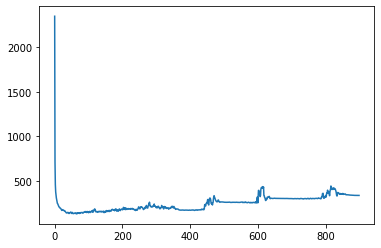

In [20]:
optimize_2l_nn(Xtrain, Xtest, Ytrain_ind, Ytest_ind, K, learning_rate=0.0001, n_epochs=100, batch_size=500, reg=0.01)